# JWST Secondary Eclipse/Emission Tutorial  

Welcome to the simulated JWST emission/secondary-eclipse spectrum model/retrieval tutorial!


For this particular setup, the atmosphere is parameterized within the "chemically-consistent" framework as described in Kreidberg et al. 2015, but for emission.  The atmospheric composition is parameterized with only a metalicity and carbon-to-oxygen ratio assumed to be in thermochemical equilibrium along the temperature-pressure profile.  Originally this code would compute the gas and condensate phase mixing ratios by calling the NASA CEA routine. However, in order to remove fortran dependencies, a finely sampled pre-computed, interpolateable chemistry grid was instead produced with CEA as a function of temperature (T from 400K - 3400K in 100K increments), pressure ($log_{10}(P)$ from -7.0 (0.1$\mu$bar) - 2.4 (316 bar) in 0.1 increments), metallicity ($[M/H]$ from -2.0 (0.01$\times$) to 3.0 (1000$\times$)), and C/O ($log_{10}(C/O)$ from -2.0 (0.01) to 0.3 (2) awkwardly spaced to better sample the transition about C/O=1). All elemental abundances are scaled with respect to the Lodders 2009 solar abundance pattern.  A pseudo-hack rainout approximation is made to the gas phase abundances of TiO, VO, Na, K, and FeH.  In this hack, these species are set to 0 abundance at levels above where they first fall below some critical value ($10^{-8}$). This is to mimic the loss of these species from the gas phase into the condensate phase. In no case are we accounting for the loss of elemental abundances.

The 3-parameter temperature profile parameterization utilizes the Guillot 2010/Parmentier et al. 2014 analytic formulism (see Line et al. 2013a for implementation details).  

This "emission" routine accounts for both stellar reflected and planetary thermal emission treated within the Toon et al. 1989 two stream + two stream source function technique (toonpy.py and toonpy_solar.py).  It accounts for multiple scattering given basic cloud optical properties (extinction efficiencies, single scatter albedo, and asymmetry parameter).   Instead of using line-by-line, or "sampled" cross-sections, this implementation uses the "correlated-K" method (see Lacis & Oinas 1990, or more recently Amundsen et al. 2017). Specifically, in multi-gas, multiple scattering atmospheres in "emission", the "resort-rebin" gas-mixing procedure has to be implemented (Molliere et al. 2015, Amundsen et al. 2017). Correlated-K is advantageous as it preserves the wavelength bin "integrated"  precision as line-by-line but with far less demanding computation.  We include as correlated-K line opacites H2O, CH4, CO, CO2, NH3, HCN, H2S, C2H2, Na, K, TiO, VO, FeH and as continuum gas opacities H2-H2, H2-He CIA, and the H- bound free and free free (e.g., Arcangeli et al. 2018).  See the "opacity" tutorial for more details on correlated-K. 

To handle the effects of disequilibrium chemistry due to vertical mixing, we apply the "quench-pressure" approximation.  We include a quench pressure parameter for the carbon-system and one for the nitrogen system (as in Morley et al. 2017 for GJ436b, and Kreidberg et al. 2018 for WASP-107b).  The carbon quench pressure fixes the H2O, CO, and CH4 abundances above the quench pressure level to their abundances at the quench pressure level.  Similarly, the nitrogen quench pressure fixes the N2, NH3, and HCN abundances above the quench pressure to their values at the quench pressure level.  This is indeed a kludge, and a better implementation would be to use the timescale/eddy mixing prescription described in Zahnle & Marley 2015.  Regardless, any non-full kinetics approach is a kludge anyway (not to mention the 1D nature of the problem...).  

There are two different cloud prescriptions built in.  The first is the Ackerman & Marley 2001 "eddy-sed" approach that self-consistently computes the vertical particle size distribution given a sedimentation factor, $f_{sed}$ and an eddy mixing factor (K$_{zz}$) from some cloud base pressure and intrinsic condensate mixing ratio.  The classic "power-law haze" and "grey cloud" prescripton is also included.  

Finally, if one doesn't like the "chemically-consistent" concept, they can use the "gas_scale" array to switch off or scale the abundances each opacity source.  

This specific notebook goes through the steps to generate the forward model, and illustrate how to actually perform the retrieval. However, the retrievals are bust run on a compute cluster or a node with more than 4 cores.  We will create a simulated JWST dataset using WASP-43b planet/star parameters, assuming the data will be binned to an R=100 (resolution of the correlated-K coefficients).

Software Requirements: This runs in the python 3 anaconda environment.  It is also crucial that anaconda numba is installed as many of the routines are optimized using numba's "@jit" decorator (http://numba.pydata.org/). 


## Import Routines

This first segment loads in the routines from fm.py and the correlated-K coefficients.  The JWST xsecs (really, correlated-K) are at an R=100 < 20 microns (> 500 cm-1) and R=50 > 20 microns (<500 cm-1).
Note that the "core" set of routines are all in fm.py.  The thermal emission radiative transfer solver is toonpy.py and the incident stellar flux solver is toonpy_solar.py  If you want to know more about what is in the sausage, look into these routines.  

In [1]:
#import all of the functions in fm, namely, the CK-coefficients (may take a minute)
from chimera import *
import os
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/lustija1/opt/anaconda3/lib/python3.8/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/lustija1/Documents/PandExo_data/pysynphot_data/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/lustija1/opt/anaconda3/lib/python3.8/site-packages/pysynphot/refs.py:117: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/lustija1/Documents/PandExo_data/pysynphot_data/mtab/*_tmg.fits
  warnings.warn('No graph or component tables found; '
/Users/lustija1/opt/anaconda3/lib/python3.8/site-packages/pysynphot/refs.py:124: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/lustija1/Documents/PandExo_data/pysynphot_data/mtab/*_tmt.fits
  warnings.warn('No thermal tables found, '


## Create Stellar File (For Emission)

In [2]:
stellar_file = 'sum_star.h5'
temp = 5000
logmh = 0 
logg = 4.0
stellar_db = 'phoenix'
make_stellar(temp,logmh,logg,stellar_db,stellar_file)

## Load Opacities

In [3]:
#preload CK-coeffs--a giant array/variable to be passed--inputs are lower wavenumber, upper wavenumber
#between 50 and 30000 cm-1 with R = 100 > 500 cm-1 (<20 um) and R=50 <500 cm-1 (>20 um)
#to convert between microns and wavenumbers-- wavelength [um] = 10,000/wavenumber [cm-1]
#make sure xsec wavenumber/wavelength range is *larger* than data wavelength range
wnomin = 750
wnomax = 15000
observatory='JWST'
directory = os.path.join(os.getcwd(),'..','..','ABSCOEFF_CK')
xsecs=xsects(wnomin, wnomax, observatory, directory,stellar_file=stellar_file)


Cross-sections Loaded


In [4]:
1e4 / xsecs[2]

array([13.2399623 , 13.10887357, 12.97908274, 12.85057697, 12.72334354,
       12.59736984, 12.4726434 , 12.34915188, 12.22688305, 12.10582481,
       11.98596515, 11.86729223, 11.74979429, 11.63345969, 11.51827692,
       11.40423458, 11.29132136, 11.1795261 , 11.06883772, 10.95924527,
       10.85073789, 10.74330484, 10.63693549, 10.5316193 , 10.42734584,
       10.32410479, 10.22188593, 10.12067914, 10.0204744 ,  9.92126178,
        9.82303146,  9.72577373,  9.62947894,  9.53413756,  9.43974016,
        9.34627739,  9.25373999,  9.1621188 ,  9.07140475,  8.98158886,
        8.89266224,  8.80461608,  8.71744166,  8.63113036,  8.54567362,
        8.46106299,  8.37729009,  8.29434663,  8.21222438,  8.13091523,
        8.05041112,  7.97070408,  7.89178622,  7.81364972,  7.73628685,
        7.65968995,  7.58385144,  7.5087638 ,  7.4344196 ,  7.36081149,
        7.28793216,  7.21577442,  7.14433111,  7.07359516,  7.00355956,
        6.93421739,  6.86556177,  6.79758591,  6.73028308,  6.66

## Setup Atmospheric Parameters 

This segement defines the various atmospheric quantities and assignes them values for the generation of a simple emission spectrum.  A description of each parameter along with a reasonable range of values is given as a comment following the assigned value. All of the parameters are then put into the parameter "state-vector" array, x.

In [5]:
#setup "input" parameters. We are defining our 1D atmosphere with these
#the parameters
#planet/star system params--xRp is the "Rp" free parameter, M right now is fixed, but could be free param
Rp=1.036  #Planet radius in Jupiter Radii--this will be forced to be 10 bar radius--arbitrary (scaling to this is free par)
Rstar=0.667 # #Stellar Radius in Solar Radii
M =2.034  #Mass in Jupiter Masses
D=0.01526   #semimajor axis in AU--for reflected light component

#TP profile params (3--Guillot 2010, Parmentier & Guillot 2013--see Line et al. 2013a for implementation)
Tirr=1400     #Irradiation temperature as defined in Guillot 2010
logKir=-1.5  #TP profile IR opacity (log there-of) controlls the "vertical" location of the gradient
logg1=-0.7     #single channel Vis/IR (log) opacity. Controls the delta T between deep T and TOA T
Tint=200 #interior temperature...this would be the "effective temperature" if object were not irradiated

#Composition parameters---assumes "chemically consistent model" described in Kreidberg et al. 2015
logMet=0.0  #.   #Metallicity relative to solar log--solar is 0, 10x=1, 0.1x = -1: valid range is -1.5 - 3.0
logCtoO=-0.26   #log C-to-O ratio: log solar is -0.26: valid range is -1.0 - 0.3 
logPQCarbon=-5.5  #CH4, CO, H2O Qunech pressure--forces CH4, CO, and H2O to constant value at quench pressure value: valid range -6.0 - 1.5
logPQNitrogen=-5.5  #N2, NH3 Quench pressure--forces N2 and NH3 to ""  

#Ackerman & Marley 2001 Cloud parameters--physically motivated with Mie particles
logKzz=7 #log Kzz (cm2/s)--valid range: 2 - 11 -- higher values make larger particles
fsed=2.0 #sediminetation efficiency--valid range: 0.5 - 5--lower values make "puffier" more extended cloud 
logPbase=-1.0  #cloud base pressure--valid range: -6.0 - 1.5
logCldVMR=-5.5 #cloud condensate base mixing ratio (e.g, see Fortney 2005)--valid range: -15 - -2.0

#simple 'grey+rayleigh' parameters just in case you don't want to use a physically motivated cloud
#(most are just made up anyway since we don't really understand all of the micro-physics.....)
logKcld = -40  #uniform in altitude and in wavelength "grey" opacity (it's a cross-section)--valid range: -50 - -10 
logRayAmp = -30  #power-law haze amplitude (log) as defined in des Etangs 2008 "0" would be like H2/He scat--valid range: -30 - 3 
RaySlope = 0  #power law index 4 for Rayleigh, 0 for "gray".  Valid range: 0 - 6

#10 bar radiuss scaling param (only used in transmission)
xRp=0.991

#stuffing all variables into state vector array
x=np.array([Tirr, logKir,logg1,Tint, logMet, logCtoO, logPQCarbon,logPQNitrogen, Rp, Rstar, M, D, logKzz, fsed,logPbase,logCldVMR, logKcld, logRayAmp, RaySlope])

#gas scaling factors to mess with turning on various species
#set to "0" to turn off a gas. Otherwise keep set at 1
#thermochemical gas profile scaling factors
# 0   1    2    3   4    5    6     7    8    9   10    11   12   13    14   15   16   17   18  19 20   21
#H2O  CH4  CO  CO2 NH3  N2   HCN   H2S  PH3  C2H2 C2H6  Na    K   TiO   VO   FeH  H    H2   He   e- h-  mmw
gas_scale=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1., 1., 1.]) #can be made free params if desired (won't affect mmw)#can be made free params if desired (won't affect mmw)

## Generate Model Atmosphere & Secondary Eclipse Spectrum

Here we call the forward model routine "fx_emis" (think F(x)) from fm.py.  fx_emis controls the input values and calls the relevent functions to compute the secondary eclipse spectrum.  The inputs into fx_emis are the parameter state vector, "x", the  data wavelength grid, "wlgrid", the gas scaling factors (for turning off particular gases), "gas_scale", and the correlated-K tables, "xsects". In this case,since we are simulated "data" at the same resolution as the model (R=100), we set wlgrid=-1 to let the spectral binning routine know not to average/convolve the spectrum.  Fx then returns the simulated model spectrum ($F_p/F_{\star}$) at the native CK-table resolution, "y_mod", the native wavenumber grid, "wno". y_binned is the same as y_mod here since there is no model "binning/averaging".  The "atm" array contains the generated temperature-pressure profile and gas mixing ratio profiles generated under the chemically consistent assumption. 

In [6]:
#calling forward model, fx. This will produce the (Fp/Fstar) spectrum....
wlgrid=-1
y_binned,y_mod,wno,atm,Ftoa,Fstar,Fstar_TOA,Fup_therm,Fup_ref=fx_emis(x,wlgrid,gas_scale, xsecs)
print('SPECTRUM GENERATE')


SPECTRUM GENERATE


## Generate Simulated Data


In [7]:
err_ppm=30. #error bar in ppm (just constant here)
err=np.ones(len(wno))*err_ppm*1E-6   #this would be a good spot to put pandexo generated error bars
                                     #though they would have to be binned/interpolated to the model wavenumber grid
y_meas = np.random.normal(y_mod, err) #adding gaussian noise
np.savetxt('simulated_emission_JWST.txt',np.array([1E4/wno, y_meas, err]).T) #saveing as txt file (wl [um], Depth, err)


## Plot Model Atmosphere  

Spaghetti plot of the model atmosphere.

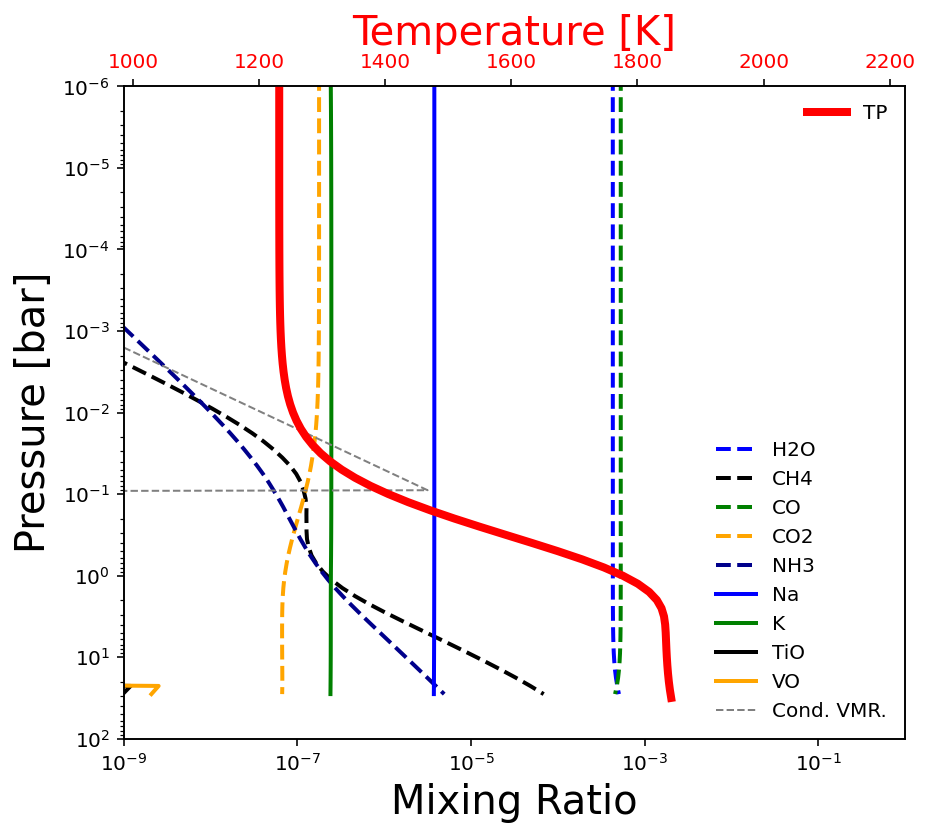

In [8]:
from matplotlib.pyplot import *
from matplotlib.ticker import FormatStrFormatter

#unpacking variables
#P is in bars
#T is in K
#H2O, CH4,CO,CO2,NH3,Na,K,TiO,VO,C2H2,HCN,H2S,FeH,H2,He are gas mixing ratio profiles
#qc is the condensate abundance profile given an "f_sed" value and cloud base pressure
#r_eff is the effective cloud droplet radius given (see A&M 2001 or Charnay et al. 2017)
#f_r is the mixing ratio array for each of the cloud droplet sizes.
P,T, H2O, CH4,CO,CO2,NH3,Na,K,TiO,VO,C2H2,HCN,H2S,FeH,H2,He,H,e, Hm,qc,r_eff,f_r=atm
Pavg=0.5*(P[1:]+P[:-1])

fig2, ax1=subplots(figsize = (7,6))
#feel free to plot whatever you want here....
ax1.semilogx(H2O,Pavg,'b',ls='--',lw=2,label='H2O')
ax1.semilogx(CH4,Pavg,'black',ls='--',lw=2,label='CH4')
ax1.semilogx(CO,Pavg,'g',ls='--',lw=2,label='CO')
ax1.semilogx(CO2,Pavg,'orange',ls='--',lw=2,label='CO2')
ax1.semilogx(NH3,Pavg,'darkblue',ls='--',lw=2,label='NH3')
ax1.semilogx(Na,Pavg,'b',lw=2,label='Na')
ax1.semilogx(K,Pavg,'g',lw=2,label='K')
ax1.semilogx(TiO,Pavg,'k',lw=2,label='TiO')
ax1.semilogx(VO,Pavg,'orange',lw=2,label='VO')
ax1.semilogx(qc,Pavg,'gray',lw=1,ls='--',label='Cond. VMR.')  #<---- A&M Cloud Condensate VMR profile (not droplets)

ax1.set_xlabel('Mixing Ratio',fontsize=20)
ax1.set_ylabel('Pressure [bar]',fontsize=20)
ax1.semilogy()
ax1.legend(loc=4,frameon=False)
ax1.axis([1E-9,1,100,1E-7])

#plotting TP profile on other x-axis
ax2=ax1.twiny()
ax2.semilogy(T,P,'r-',lw='4',label='TP')
ax2.set_xlabel('Temperature [K]',color='r',fontsize=20)
ax2.axis([0.8*T.min(),1.2*T.max(),100,1E-6])
for tl in ax2.get_xticklabels(): tl.set_color('r')
ax2.legend(loc=1,frameon=False)

#savefig('./plots/atmosphere_emission_JWST_CC.pdf',fmt='pdf')
#show()
#close()





## Plot Secondary Eclipse Spectrum Model and Data 


In [10]:
import smart
import smarter; smarter.utils.plot_setup()
import astropy.units as u

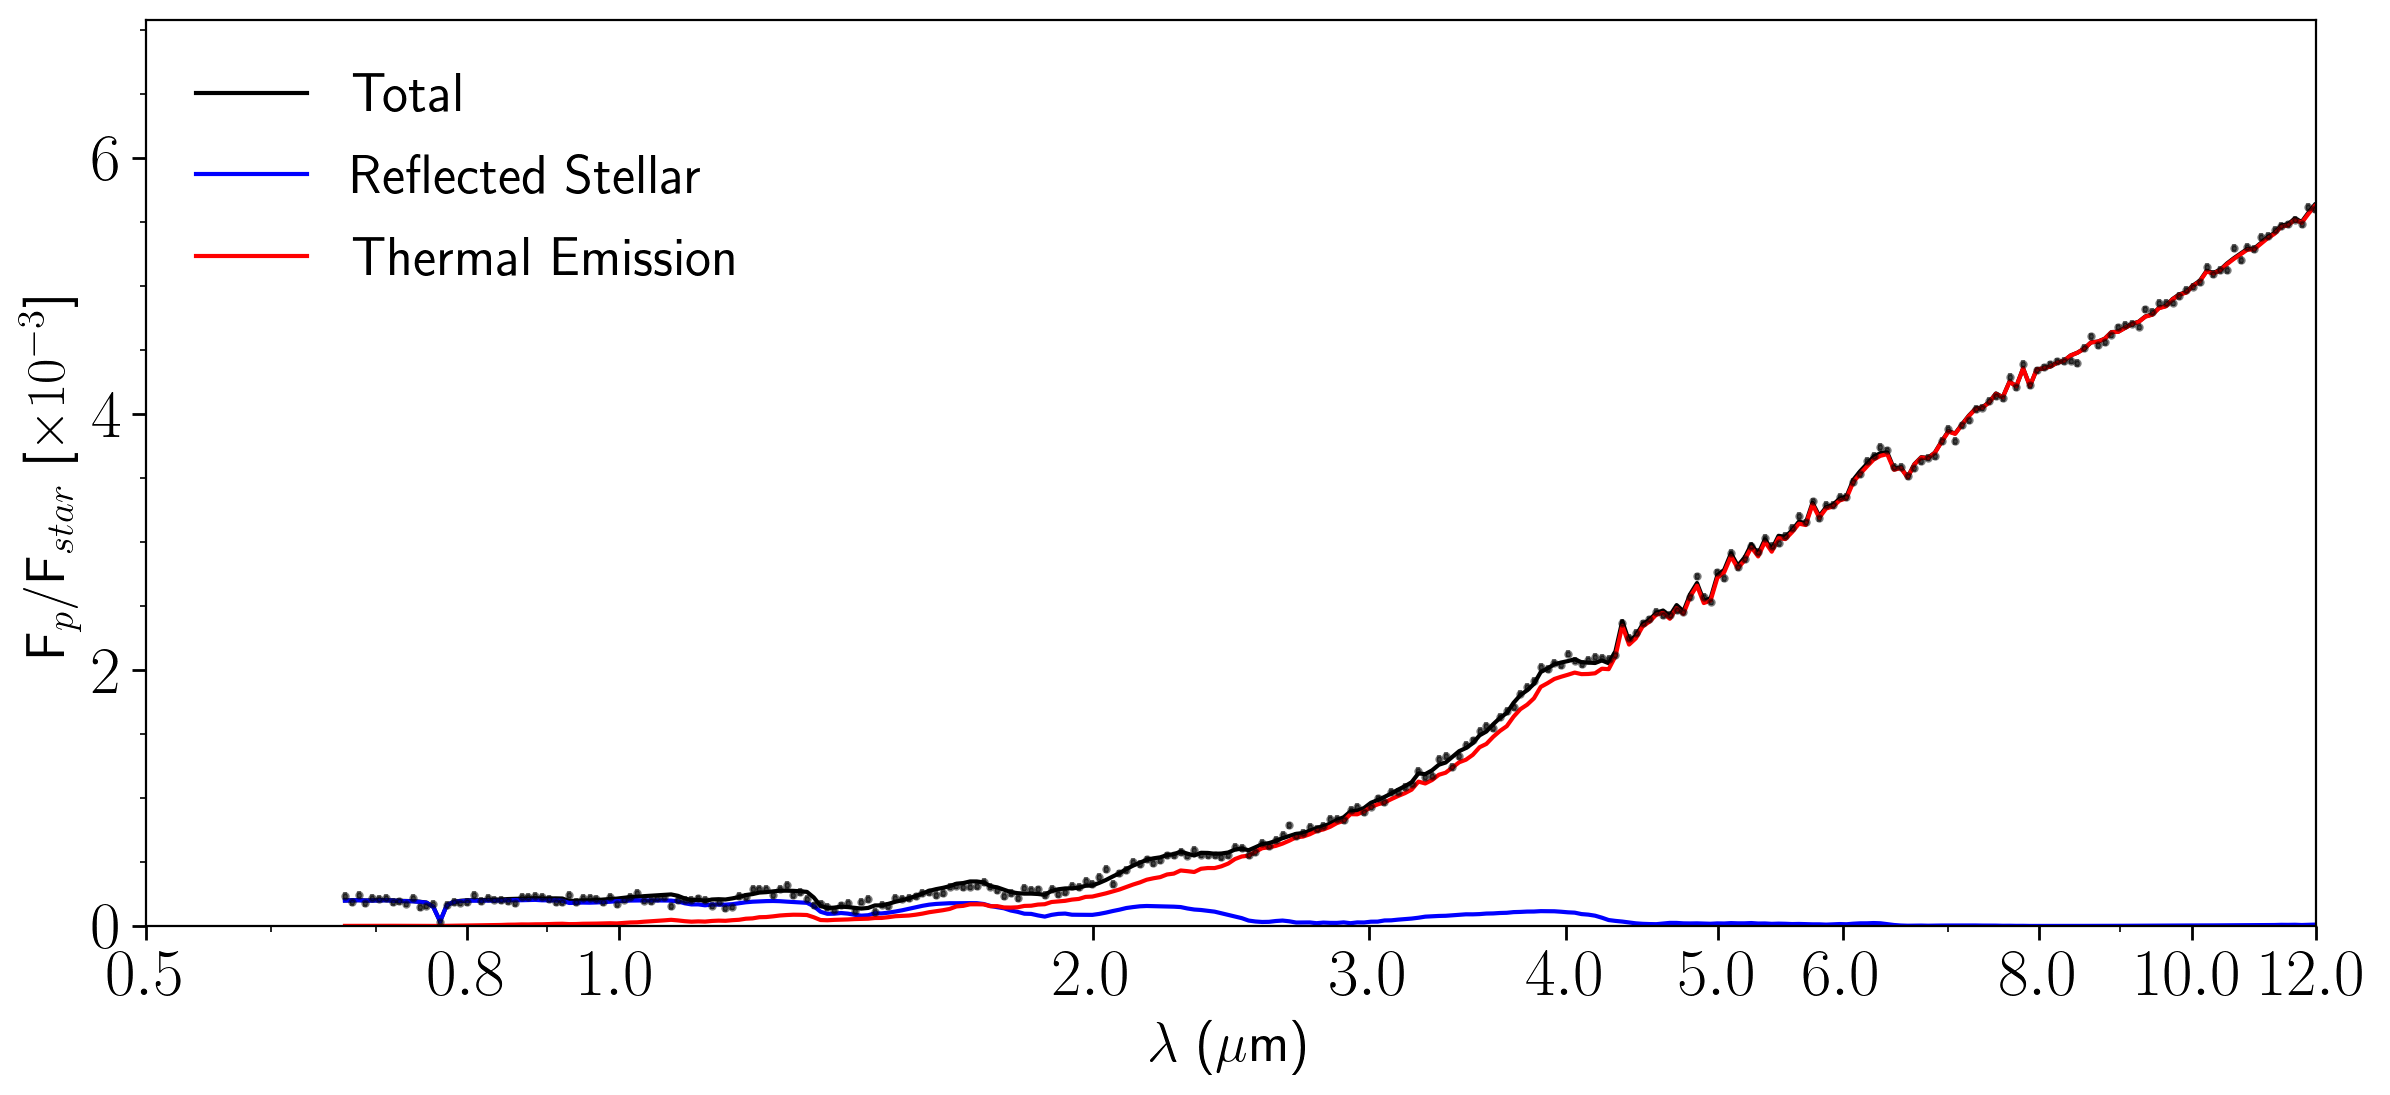

In [12]:
ymin=0
ymax=np.max(y_mod)*1E3*1.2
fig1, ax=subplots(figsize = (14,6))
xlabel('$\lambda$ ($\mu$m)')
ylabel('F$_p$/F$_{star}$ [$\\times 10^{-3}$]')
minorticks_on()
errorbar(1E4/wno, y_meas*1E3, yerr=err*1E3, xerr=None, fmt='ok',ms=2, alpha=0.5)
plot(1E4/wno, y_mod*1E3,color='black',label='Total')
#reflected component
plot(1E4/wno, Fup_ref/Fstar*1E3*(Rp/Rstar*0.10279)**2 ,color='blue',label='Reflected Stellar')
#emission component
plot(1E4/wno, Fup_therm/Fstar*1E3*(Rp/Rstar*0.10279)**2 ,color='red',label='Thermal Emission ')

legend(frameon=False)

ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xticks([0.3, 0.5,0.8,1, 2, 3, 4, 5, 6, 8, 10, 12])
ax.axis([0.5,12,ymin,ymax])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.tick_params(length=5,width=1,labelsize='large',which='major')
#savefig('./plots/emission_spectrum_JWST_CC.pdf',fmt='pdf')

In [14]:
dist = 80.0
Bstar = np.pi*1e6*smart.analysis.planck(temp, wl)
Fstar_earth = Bstar*( Rstar * u.Rsun.in_units(u.m) / (dist * u.pc.in_units(u.m)))**2
Fstar_earth = Fstar*( Rstar * u.Rsun.in_units(u.m) / (dist * u.pc.in_units(u.m)))**2

Fplan_earth = Ftoa * ( Rp * u.Rjup.in_units(u.m) / (dist * u.pc.in_units(u.m)))**2
Fplan_therm_earth = Fup_therm * ( Rp * u.Rjup.in_units(u.m) / (dist * u.pc.in_units(u.m)))**2

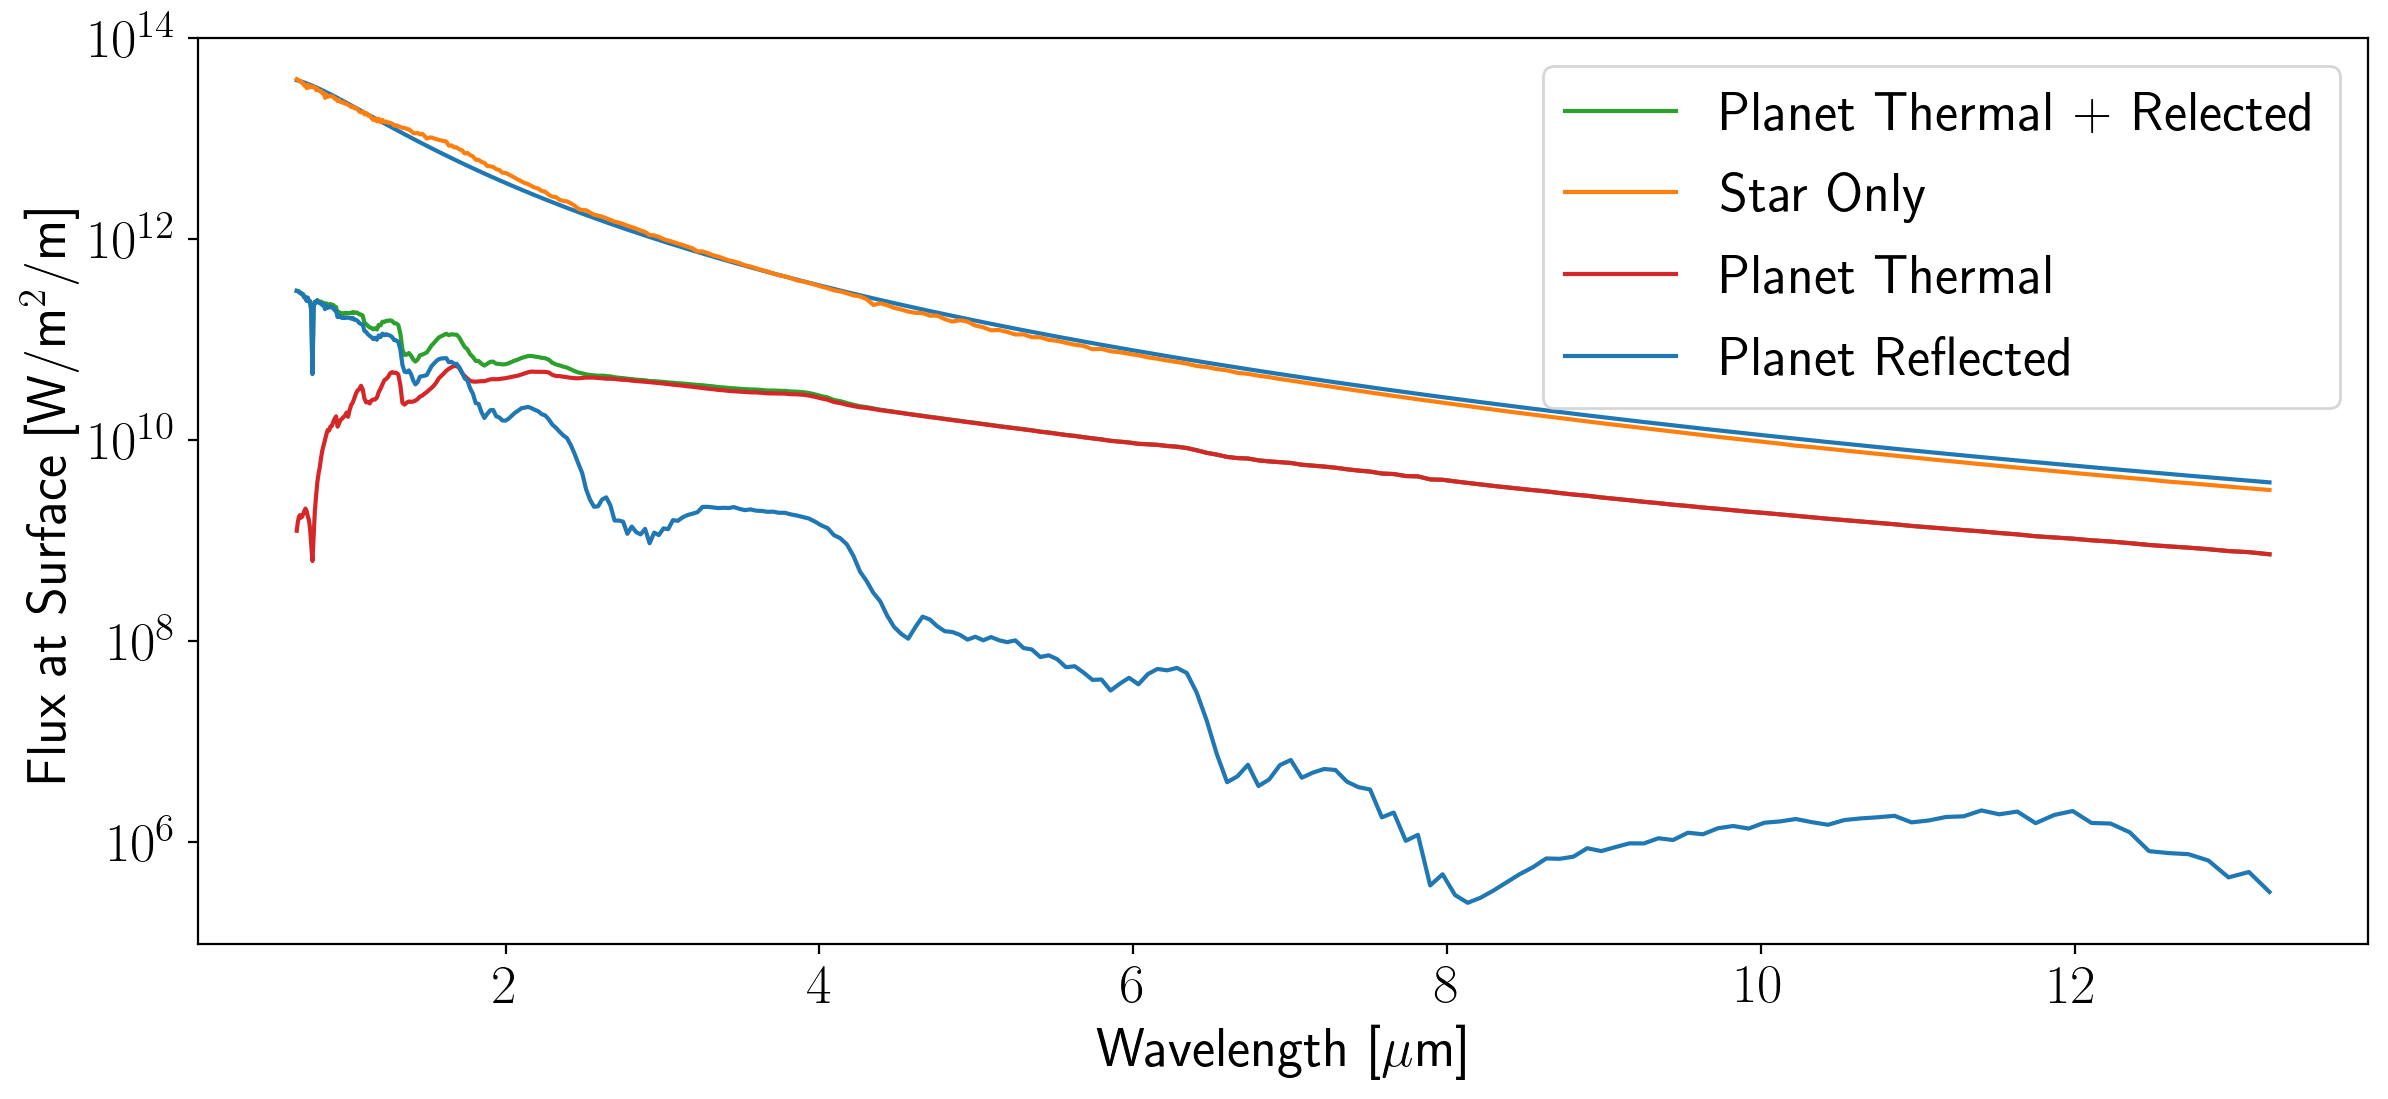

In [25]:
wl = 1e4/wno 

fig, ax = plt.subplots(figsize = (14, 6))
ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("Flux at Surface [W/m$^2$/m]")

ax.plot(wl, Bstar)
ax.plot(wl, Ftoa, label = "Planet Thermal + Relected", color = "C2")
ax.plot(wl, Fstar, label = "Star Only", color = "C1")
ax.plot(wl, Fup_therm, label = "Planet Thermal", color = "C3")
ax.plot(wl, Fup_ref, label = "Planet Reflected", color = "C0")
#ax.plot(wl, Fup_therm + Fup_ref)
ax.set_yscale("log")
ax.legend()

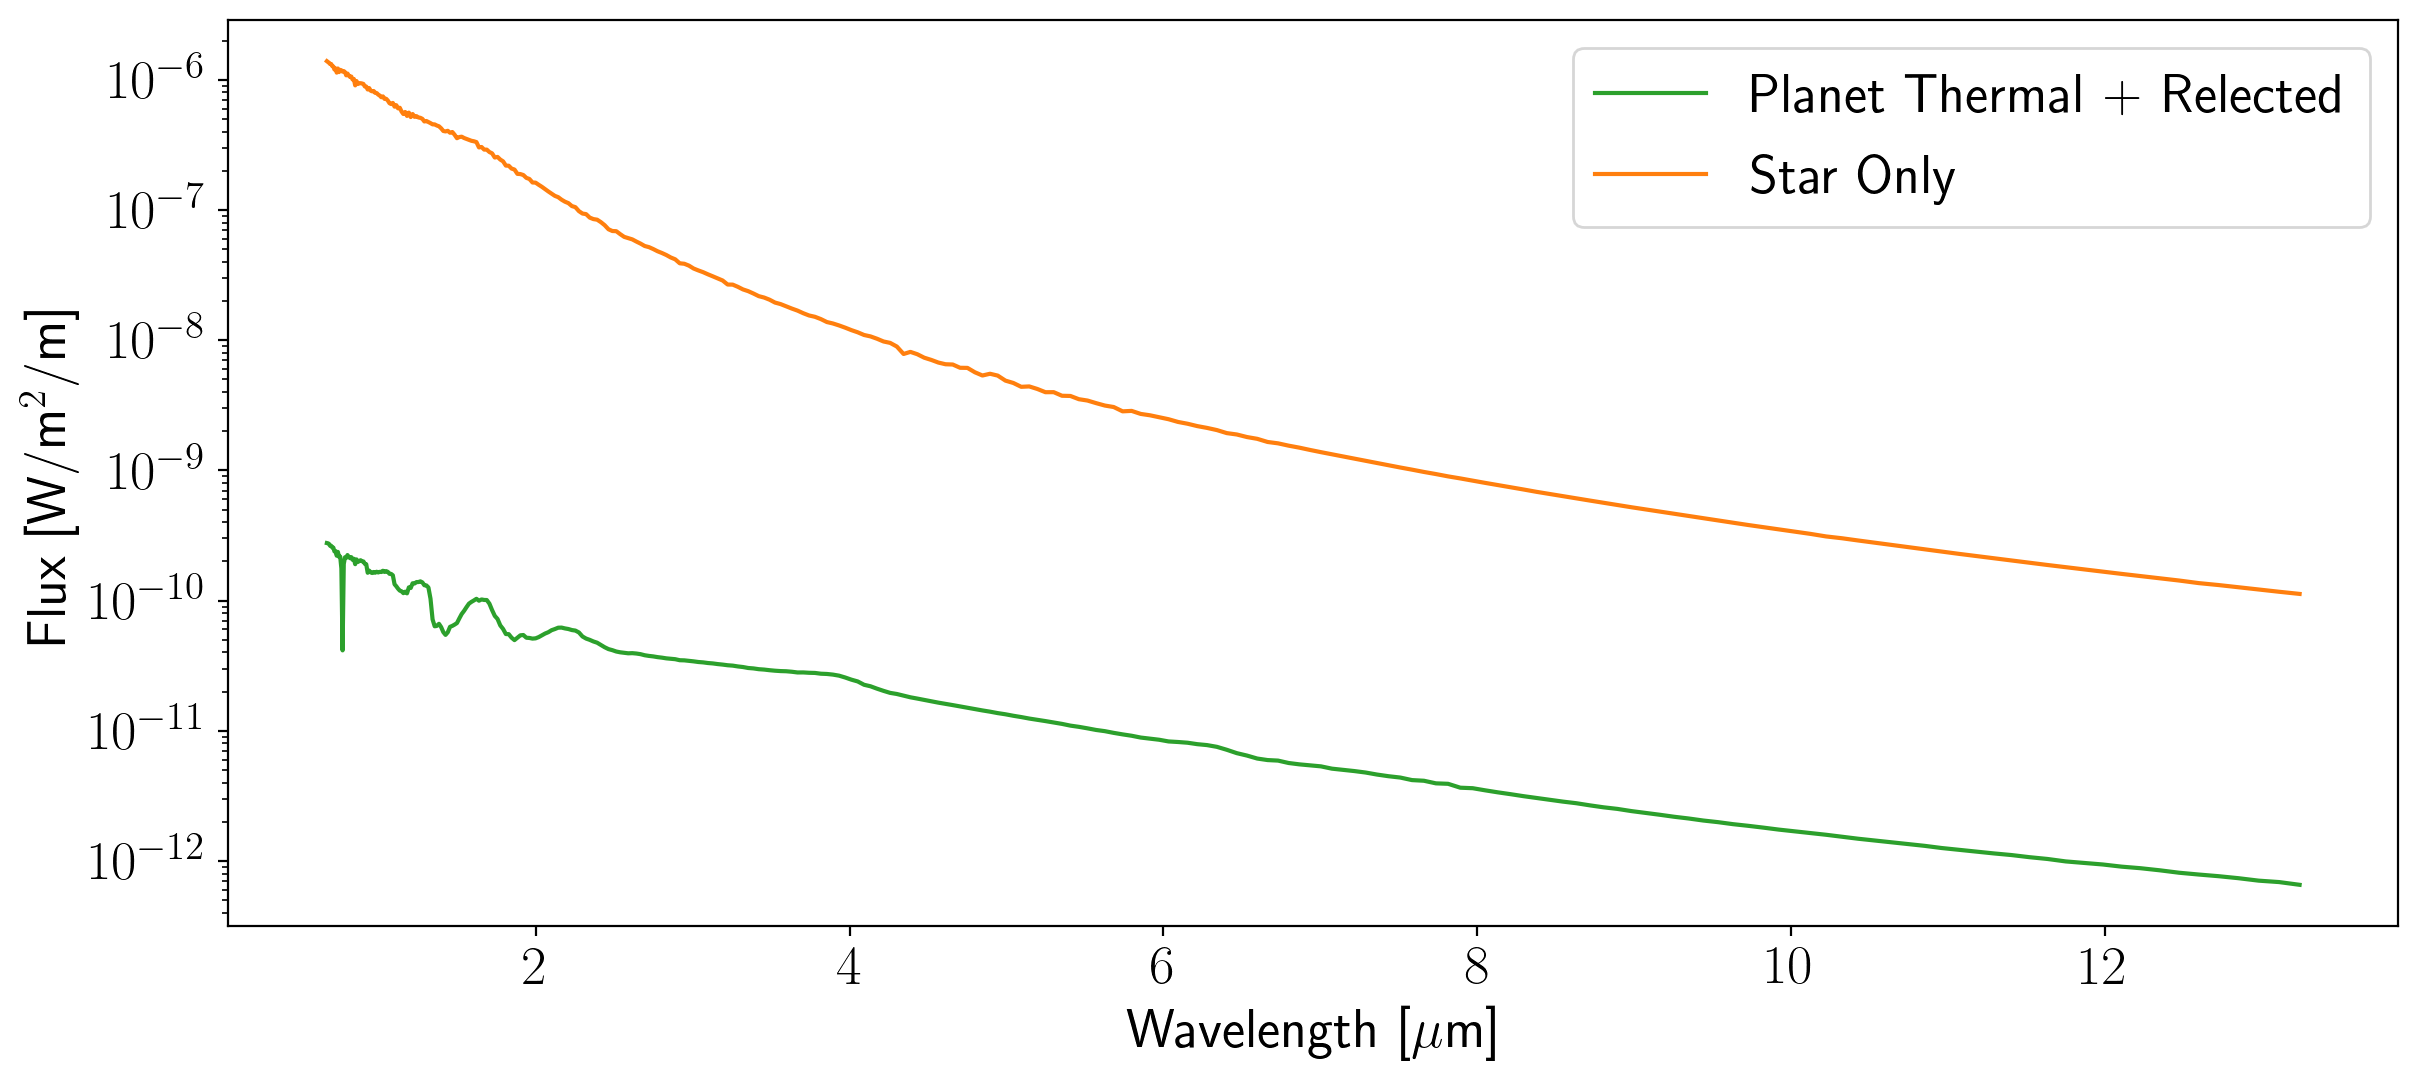

In [21]:
fig, ax = plt.subplots(figsize = (14, 6))
ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("Flux [W/m$^2$/m]")

ax.plot(wl, Fplan_earth, label = "Planet Thermal + Relected", color = "C2")
ax.plot(wl, Fstar_earth, label = "Star Only", color = "C1")
#ax.plot(wl,(Fplan_earth/Fstar_earth), label = "Star Only", color = "C1")
#ax.plot(wl, Fup_therm, label = "Planet Thermal", color = "C3")
#ax.plot(wl, Fup_ref, label = "Planet Reflected", color = "C0")
#ax.plot(wl, Fup_therm + Fup_ref)
ax.set_yscale("log")
ax.legend()

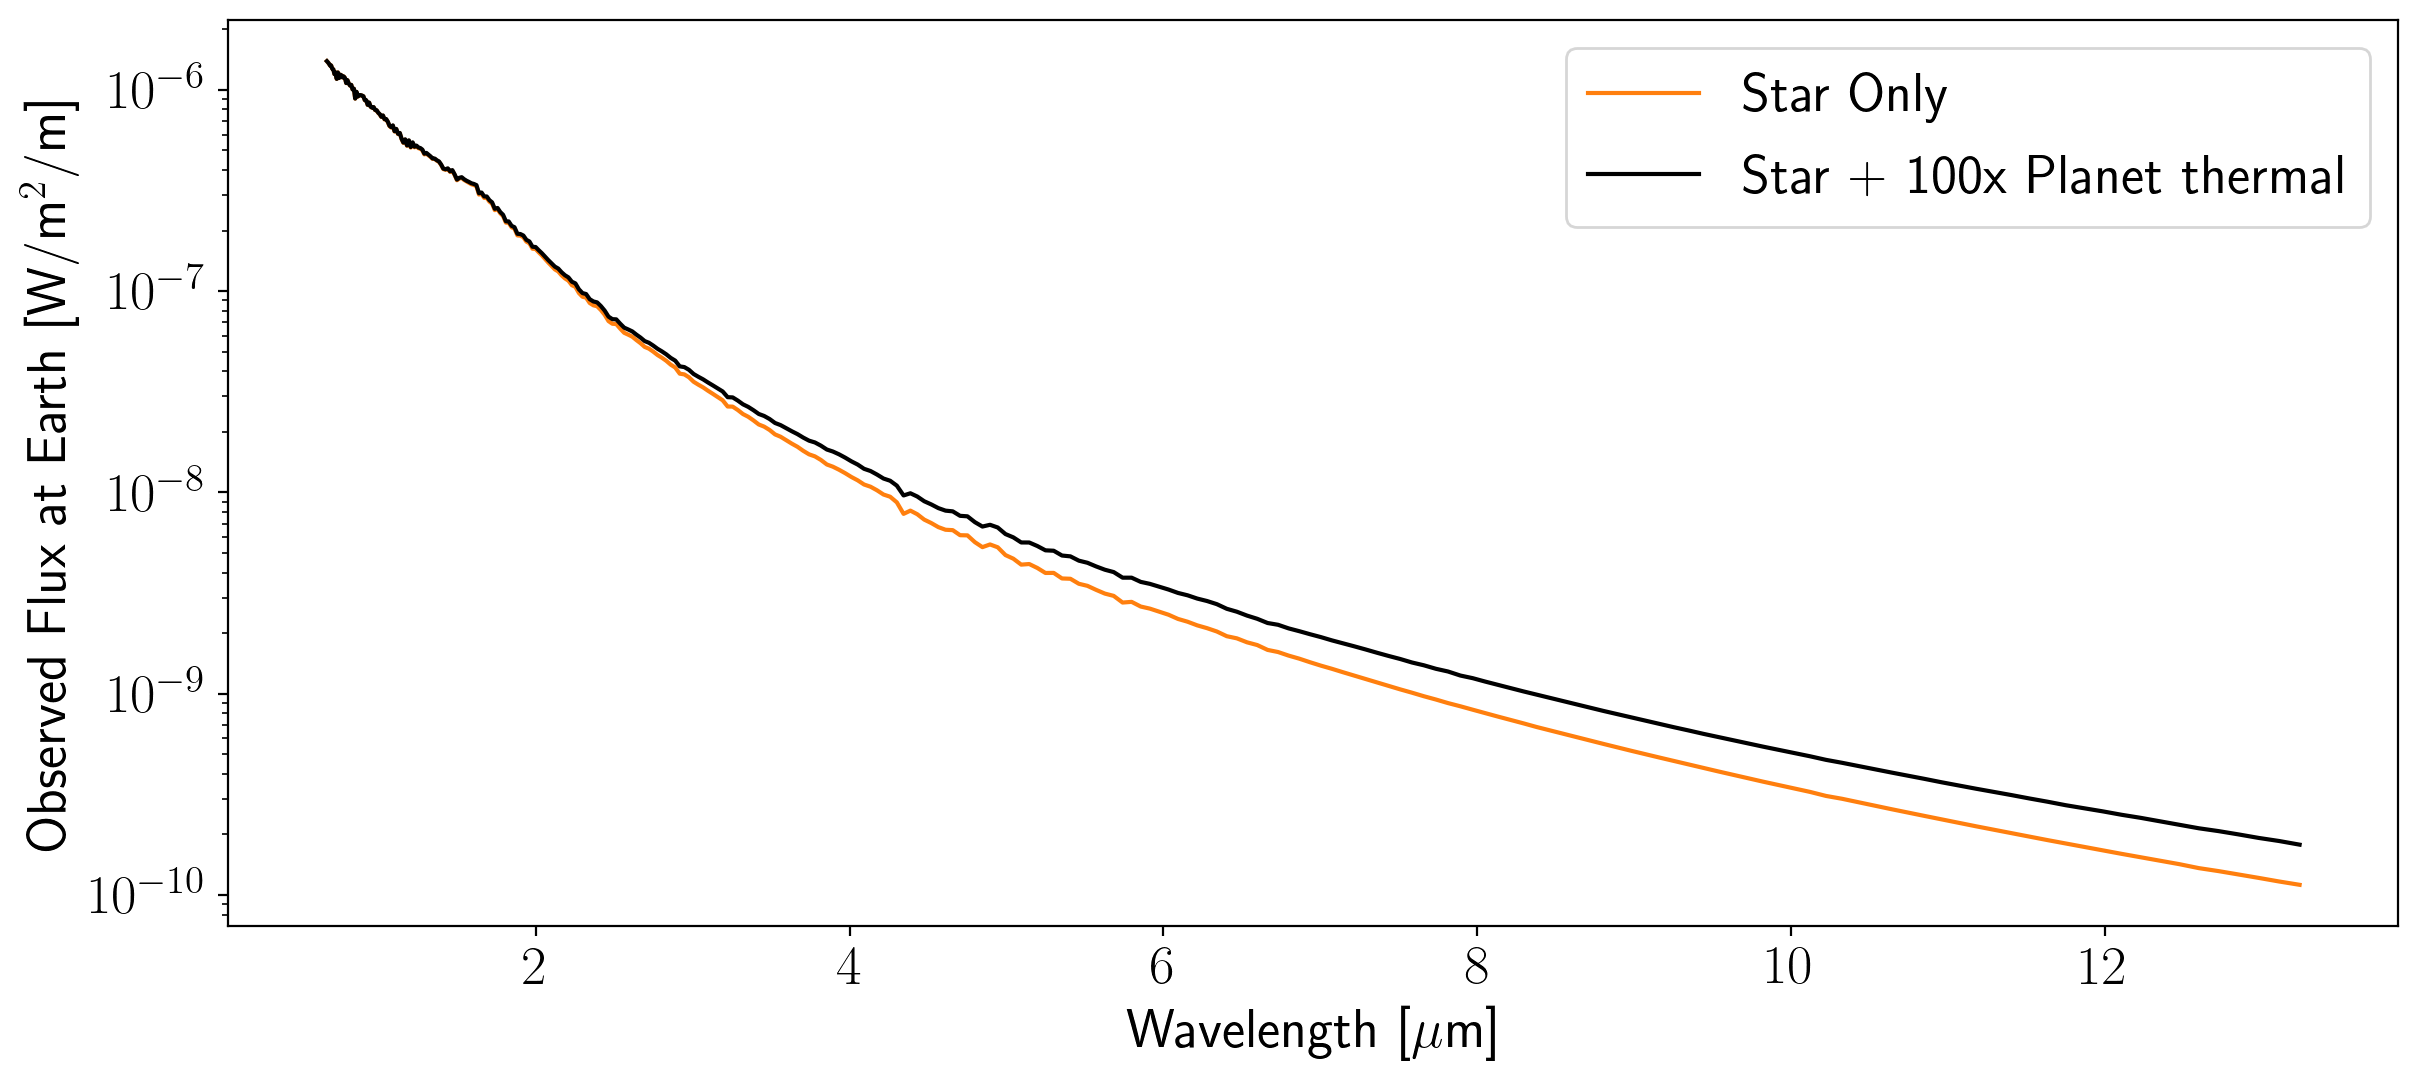

In [28]:
wl = 1e4/wno 

fig, ax = plt.subplots(figsize = (14, 6))

ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("Observed Flux at Earth [W/m$^2$/m]")

#ax.plot(wl, Ftoa, label = "Planet Thermal + Relected", color = "C2")
#ax.plot(wl, Fstar, label = "Star Only", color = "C1")
#ax.plot(wl, Fstar + Fup_therm, label = "Star + Planet thermal", color = "k")
#ax.plot(wl, Fup_therm, label = "Planet Thermal", color = "C3")
#ax.plot(wl, Fup_ref, label = "Planet Reflected", color = "C0")
#ax.plot(wl, Fup_therm + Fup_ref)

ax.plot(wl, Fstar_earth, label = "Star Only", color = "C1")
ax.plot(wl, Fstar_earth + 100*Fplan_therm_earth, label = "Star + 100x Planet thermal", color = "k")

ax.set_yscale("log")
ax.legend()

## Play around with Secondary Eclipse Spectrum

### Explore cloud contribution

SPECTRUM GENERATE1
SPECTRUM GENERATE2


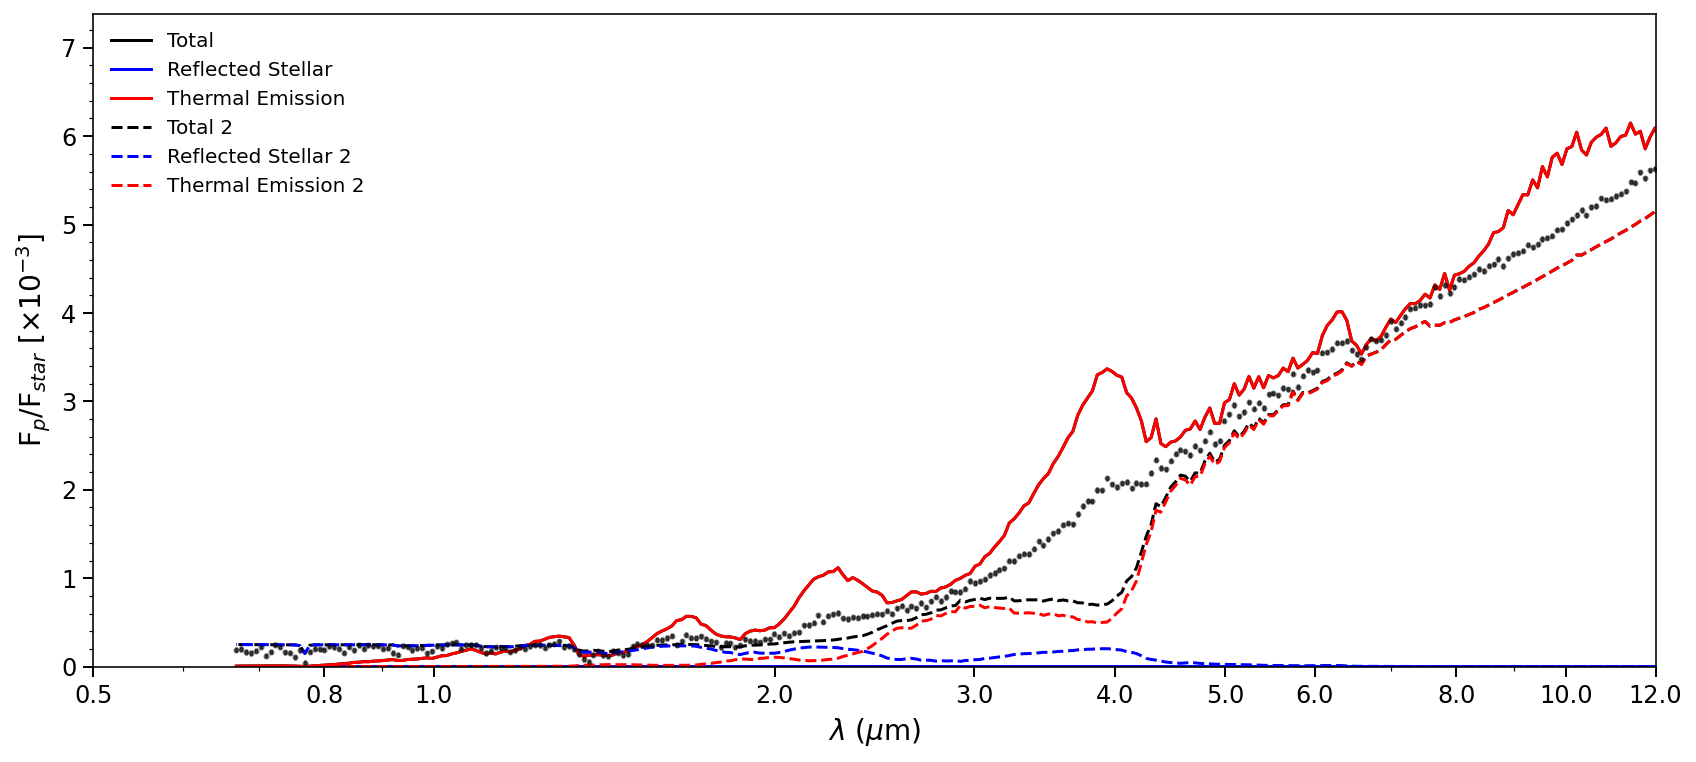

In [17]:
from matplotlib.pyplot import *
from matplotlib.ticker import FormatStrFormatter


#setup "input" parameters. We are defining our 1D atmosphere with these
#the parameters
#planet/star system params--xRp is the "Rp" free parameter, M right now is fixed, but could be free param
Rp=1.036  #Planet radius in Jupiter Radii--this will be forced to be 10 bar radius--arbitrary (scaling to this is free par)
Rstar=0.667 # #Stellar Radius in Solar Radii
M =2.034  #Mass in Jupiter Masses
D=0.01526   #semimajor axis in AU--for reflected light component

#TP profile params (3--Guillot 2010, Parmentier & Guillot 2013--see Line et al. 2013a for implementation)
Tirr=1400     #Irradiation temperature as defined in Guillot 2010
logKir=-1.5  #TP profile IR opacity (log there-of) controlls the "vertical" location of the gradient
logg1=-0.7     #single channel Vis/IR (log) opacity. Controls the delta T between deep T and TOA T
Tint=200 #interior temperature...this would be the "effective temperature" if object were not irradiated

#Composition parameters---assumes "chemically consistent model" described in Kreidberg et al. 2015
logMet=0.0  #.   #Metallicity relative to solar log--solar is 0, 10x=1, 0.1x = -1: valid range is -1.5 - 3.0
logCtoO=-0.26   #log C-to-O ratio: log solar is -0.26: valid range is -1.0 - 0.3 
logPQCarbon=-5.5  #CH4, CO, H2O Qunech pressure--forces CH4, CO, and H2O to constant value at quench pressure value: valid range -6.0 - 1.5
logPQNitrogen=-5.5  #N2, NH3 Quench pressure--forces N2 and NH3 to ""  

#Ackerman & Marley 2001 Cloud parameters--physically motivated with Mie particles
logKzz=7 #log Kzz (cm2/s)--valid range: 2 - 11 -- higher values make larger particles
fsed=2.0 #sediminetation efficiency--valid range: 0.5 - 5--lower values make "puffier" more extended cloud 
logPbase=-1.0  #cloud base pressure--valid range: -6.0 - 1.5
logCldVMR=-25.5 #cloud condensate base mixing ratio (e.g, see Fortney 2005)--valid range: -15 - -2.0

#for second model
logKzz2=7 #log Kzz (cm2/s)--valid range: 2 - 11 -- higher values make larger particles
fsed2=0.5 #sediminetation efficiency--valid range: 0.5 - 5--lower values make "puffier" more extended cloud 
logPbase2=1.0  #cloud base pressure--valid range: -6.0 - 1.5
logCldVMR2=-3. #cloud condensate base mixing ratio (e.g, see Fortney 2005)--valid range: -15 - -2.0


#simple 'grey+rayleigh' parameters just in case you don't want to use a physically motivated cloud
#(most are just made up anyway since we don't really understand all of the micro-physics.....)
logKcld = -40  #uniform in altitude and in wavelength "grey" opacity (it's a cross-section)--valid range: -50 - -10 
logRayAmp = -30  #power-law haze amplitude (log) as defined in des Etangs 2008 "0" would be like H2/He scat--valid range: -30 - 3 
RaySlope = 0  #power law index 4 for Rayleigh, 0 for "gray".  Valid range: 0 - 6

#10 bar radiuss scaling param (only used in transmission)
xRp=0.991

#stuffing all variables into state vector array
x=np.array([Tirr, logKir,logg1,Tint, logMet, logCtoO, logPQCarbon,logPQNitrogen, Rp, Rstar, M, D, logKzz, fsed,logPbase,logCldVMR, logKcld, logRayAmp, RaySlope])
x2=np.array([Tirr, logKir,logg1,Tint, logMet, logCtoO, logPQCarbon,logPQNitrogen, Rp, Rstar, M, D, logKzz2, fsed2,logPbase2,logCldVMR2, logKcld, logRayAmp, RaySlope])


#gas scaling factors to mess with turning on various species
#set to "0" to turn off a gas. Otherwise keep set at 1
#thermochemical gas profile scaling factors
# 0   1    2    3   4    5    6     7    8    9   10    11   12   13    14   15   16   17   18  19 20   21
#H2O  CH4  CO  CO2 NH3  N2   HCN   H2S  PH3  C2H2 C2H6  Na    K   TiO   VO   FeH  H    H2   He   e- h-  mmw
gas_scale=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1., 1., 1.]) #can be made free params if desired (won't affect mmw)#can be made free params if desired (won't affect mmw)

y_binned,y_mod,wno,atm,Ftoa,Fstar,Fstar_TOA,Fup_therm,Fup_ref=fx_emis(x,wlgrid,gas_scale, xsecs)
print('SPECTRUM GENERATE1')
y_binned2,y_mod2,wno2,atm2,Ftoa2,Fstar2,Fstar_TOA2,Fup_therm2,Fup_ref2=fx_emis(x2,wlgrid,gas_scale, xsecs)
print('SPECTRUM GENERATE2')

ymin=0
ymax=np.max(y_mod)*1E3*1.2
fig1, ax=subplots(figsize = (14,6))
xlabel('$\lambda$ ($\mu$m)',fontsize=14)
ylabel('F$_p$/F$_{star}$ [$\\times 10^{-3}$]',fontsize=14)
minorticks_on()
errorbar(1E4/wno, y_meas*1E3, yerr=err*1E3, xerr=None, fmt='ok',ms=2, alpha=0.5)
plot(1E4/wno, y_mod*1E3,color='black',label='Total')
#reflected component
plot(1E4/wno, Fup_ref/Fstar*1E3*(Rp/Rstar*0.10279)**2 ,color='blue',label='Reflected Stellar')
#emission component
plot(1E4/wno, Fup_therm/Fstar*1E3*(Rp/Rstar*0.10279)**2 ,color='red',label='Thermal Emission ')

plot(1E4/wno, y_mod2*1E3,color='black',label='Total 2',ls='--')
#reflected component
plot(1E4/wno, Fup_ref2/Fstar2*1E3*(Rp/Rstar*0.10279)**2 ,color='blue',label='Reflected Stellar 2',ls='--')
#emission component
plot(1E4/wno, Fup_therm2/Fstar2*1E3*(Rp/Rstar*0.10279)**2 ,color='red',label='Thermal Emission 2 ',ls='--')



legend(frameon=False)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xticks([0.3, 0.5,0.8,1, 2, 3, 4, 5, 6, 8, 10, 12])
ax.axis([0.5,12,ymin,ymax])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.tick_params(length=5,width=1,labelsize='large',which='major')

#show()




## Doing the Retrieval "off line" with PyMultiNest 
We'll leave it as an exercise for the "reader" to adapt one of the other routines

